In [348]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler

In [349]:
temperature_data = pd.read_csv('cleaned_temperature_data_US.csv')
temperature_data = temperature_data[temperature_data["year"] <= 2021]
temperature_data.head()

,month,year,average_temp,average_historic,net_difference
0,1.0,1950.0,33.052083,30.556250,2.495833
1,2.0,1950.0,32.939583,30.572917,2.366667
2,3.0,1950.0,35.216667,36.264583,-1.047917
3,4.0,1950.0,42.222917,45.387500,-3.164583
4,5.0,1950.0,53.454167,55.197917,-1.743750


In [350]:
temps = temperature_data.groupby('year')['net_difference'].mean()

In [351]:
emissions_data = pd.read_csv('GCB2022v27_MtCO2_flat.csv')
emissions_data = emissions_data[emissions_data['Year'] >= 1950]


emissions_data = emissions_data[emissions_data['Country'] == 'Global']
emissions_data.head()

,Country,ISO 3166-1 alpha-3,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
63032,Global,WLD,1950,6003.271922,3856.215025,1648.309543,353.156200,66.978938,73.624416,NaN,2.401960
63033,Global,WLD,1951,6379.796307,4060.039800,1742.354432,416.186336,75.839229,79.875260,NaN,2.508639
63034,Global,WLD,1952,6465.726953,4009.059071,1838.023921,447.085044,80.840562,85.363804,NaN,2.496159
63035,Global,WLD,1953,6647.763209,4043.705068,1952.100332,474.527427,89.627553,81.348030,NaN,2.517826
63036,Global,WLD,1954,6789.968651,4039.512096,2068.542651,501.349623,97.230969,77.612011,NaN,2.522296


In [352]:
emissions_data["temperature_diffs"] = temps.values

In [353]:
# set up X without target variable, make y only target
X = emissions_data.drop(["Country", "ISO 3166-1 alpha-3", "Other", "temperature_diffs", "Year"], axis = 1)
y = emissions_data["temperature_diffs"]

# set seed for reproducibility, then create training and testing splits
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed)

In [354]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [355]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_train.head()

,Total,Coal,Oil,Gas,Cement,Flaring,Per Capita
0,1.799720,1.924442,1.441575,1.866834,2.095665,1.297597,1.222823
1,-1.277085,-1.044629,-1.542663,-1.134387,-0.933971,-1.316012,-1.782352
2,0.411835,0.220164,0.568722,0.482006,0.052665,0.052931,0.334856
3,0.567476,0.352565,0.729406,0.637420,0.287040,0.109622,0.367639
4,0.183491,0.173306,0.378355,0.022394,-0.184790,-0.572932,0.438368


In [356]:
X_test = pd.DataFrame(X_test, columns=X.columns)
X_test.head()

,Total,Coal,Oil,Gas,Cement,Flaring,Per Capita
0,-0.533232,-0.625192,-0.374430,-0.579176,-0.546986,0.052756,-0.052602
1,1.122472,1.083476,1.121641,1.073038,0.934439,0.903021,0.907737
2,-0.990822,-0.729980,-1.202105,-0.972412,-0.789003,-1.250452,-0.985952
3,1.875966,1.992504,1.448358,2.040021,2.226598,1.466907,1.280818
4,0.917378,0.792657,0.988315,0.938419,0.695081,0.518365,0.650568


In [357]:
y_train[:5]

63099    2.537674
63035    1.587674
63075   -0.575521
63079    0.098611
63068    0.880556
Name: temperature_diffs, dtype: float64

In [358]:
y_test[:5]

63051   -0.702431
63087    1.677604
63042   -0.387847
63100    1.498785
63085    0.768576
Name: temperature_diffs, dtype: float64

In [359]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Create Time Series Features

# Create XGBoost Model

- Training Score: 0.975
- Test Score: 0.624
- R2 Score: 0.353

- Mean Square Error: 0.380
- Mean Absolute Error: 0.506
- Mean Absolute Percent Error: 0.905

In [360]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False,
       ) # Change verbose to True if you want to see it train

reg_yhat = reg.predict(X_test)

reg.score(X_train, y_train), reg.score(X_test, y_test), r2_score(reg_yhat, y_test)

c:\Users\zach3\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



(0.974606375728209, 0.6243293013555877, 0.35340879506368184)

In [361]:
mean_squared_error(reg_yhat, y_test), mean_absolute_error(reg_yhat, y_test), mean_absolute_percentage_error(reg_yhat, y_test)

(0.380110423088699, 0.5063476911278519, 0.904951253510522)

# Support Vector Machine - Regression Model


- Training Score: 0.627
- Test Score: 0.277
- R2 Score: 0.382

- Mean Square Error: 0.732
- Mean Absolute Error: 0.675
- Mean Absolute Percent Error: 1.120

In [362]:
clf = svm.SVR(C=100, kernel = 'rbf')
clf.fit(X_train, y_train)
clf_yhat = clf.predict(X_test)

clf.score(X_train, y_train), clf.score(X_test, y_test), r2_score(clf_yhat, y_test)

(0.6271425021271415, 0.2765457651476455, 0.3823594531571767)

In [363]:
mean_squared_error(clf_yhat, y_test), mean_absolute_error(clf_yhat, y_test), mean_absolute_percentage_error(clf_yhat, y_test)

(0.7320041096825899, 0.6747305307771478, 1.119614414962066)

# Linear Regression Model

- Training Score: 0.547
- Test Score: 0.373
- R2 Score: -0.101

- Mean Square Error: 0.635
- Mean Absolute Error: 0.659
- Mean Absolute Percent Error: 1.113

In [364]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)
lr.score(X_train, y_train), lr.score(X_test, y_test), r2_score(lr_yhat, y_test)

(0.5469983435435746, 0.3729277317749804, -0.10070255764816816)

In [365]:
mean_squared_error(lr_yhat, y_test), mean_absolute_error(lr_yhat, y_test), mean_absolute_percentage_error(lr_yhat, y_test)

(0.6344830886260224, 0.6585549561973173, 1.1131481159685153)

## XGBoost Feature Importances

Only the XGBoost model has feature importance graph, and when we look at that it has determined that overall emissions is the most important factor. It additionally found Flaring to be slightly more important than the others too. Cement and Gas emissions were deemed to be the least important factors


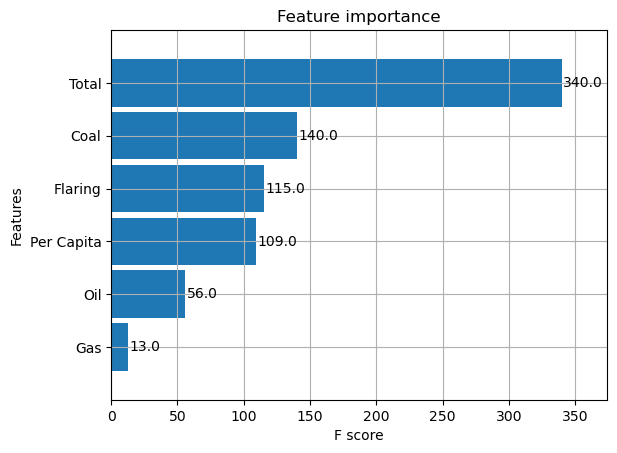

In [366]:
_ = plot_importance(reg, height=0.9)

# LR Coefficients

These coefficients are essentially feature importance to the LR Model.

In [367]:
for i in range(len(lr.coef_)):
    print(f"{lr.feature_names_in_[i]} has coef {lr.coef_[i]}")

Total has coef -68.6544132218928
Coal has coef 27.69528090874344
Oil has coef 24.088686902006966
Gas has coef 19.26163453144098
Cement has coef 0.18862582374078476
Flaring has coef 1.5237675815393406
Per Capita has coef -1.2992220242291914


# SVM Feature Importance/Coefficients

SVR has no methods that are equivalent to these. SVR instead use support vectors. Each support vector is length 7 since there are 7 features of the model in total. A support vector essentially denotes a single data point and its values of the corresponding features. The model then uses a collection of these points called the support vectors to determine the predicted values. The first vector can be seen below. There are 39 in total.

In [368]:
clf.support_vectors_[1], len(clf.support_vectors_)

(array([-1.27708547, -1.04462926, -1.5426633 , -1.13438705, -0.93397052,
        -1.31601201, -1.78235227]),
 37)

# Plotting Residuals

In [369]:
residuals = reg_yhat - y_test
residuals.sort_index(ascending=True, inplace=True)


fig = px.line(x=residuals.keys(), y=residuals.values, title='Residuals of XGBoost Model')

fig2 = px.scatter(x=residuals.keys(), y=residuals.values, trendline='ols', trendline_color_override='#C70039')
fig2.data[1].name = 'Residual Trendline'
fig2.data[1].showlegend = True

fig.add_trace(fig2.data[1])

fig.update_layout(height=600, width=600, template='plotly_dark')
fig.show()

In [370]:
y_test_sorted= y_test.sort_index(ascending=True)

fig = make_subplots()

fig.add_trace(
    go.Scatter(x=y_test_sorted.keys(), y=y_test_sorted.values, name='Actual Values', mode='lines', line=dict(color="#FFC300"))
)

fig.add_trace(
    go.Scatter(x=y_test_sorted.keys(), y=reg_yhat, name='Predicted Values', mode='lines', line=dict(color="#4462FA"))
)

# Add figure title
fig.update_layout(
    title_text="XGBoost Test Set"
)

# Set x-axis title
fig.update_xaxes(title_text="Index")

# Set y-axes titles
fig.update_yaxes(title_text="Net Temperature Difference", secondary_y=False)

fig.update_layout(height=600, width=1200, template='plotly_dark')
fig.show()

In [371]:
residuals = clf_yhat - y_test
residuals.sort_index(ascending=True, inplace=True)

fig = px.line(x=residuals.keys(), y=residuals.values, title='Residuals of SVM Model')

fig2 = px.scatter(x=residuals.keys(), y=residuals.values, trendline='ols', trendline_color_override='#C70039')
fig2.data[1].name = 'Residual Trendline'
fig2.data[1].showlegend = True

fig.add_trace(fig2.data[1])

fig.update_layout(height=600, width=600, template='plotly_dark')
fig.show()

In [372]:
fig = make_subplots()

fig.add_trace(
    go.Scatter(x=y_test_sorted.keys(), y=y_test_sorted.values, name='Actual Values', mode='lines', line=dict(color="#FFC300"))
)

fig.add_trace(
    go.Scatter(x=y_test_sorted.keys(), y=clf_yhat, name='Predicted Values', mode='lines', line=dict(color="#4462FA"))
)

# Add figure title
fig.update_layout(
    title_text="Support Vector Machine Test Set"
)

# Set x-axis title
fig.update_xaxes(title_text="Index")

# Set y-axes titles
fig.update_yaxes(title_text="Net Temperature Difference", secondary_y=False)

fig.update_layout(height=600, width=1200, template='plotly_dark')
fig.show()

In [373]:
residuals = lr_yhat - y_test
residuals.sort_index(ascending=True, inplace=True)

fig = px.line(x=residuals.keys(), y=residuals.values, title='Residuals of LR Model')
# print(fig.data[1])
# fig.data[1].showlegend = True

fig2 = px.scatter(x=residuals.keys(), y=residuals.values, trendline='ols', trendline_color_override='#C70039')
fig2.data[1].name = 'Residual Trendline'
fig2.data[1].showlegend = True

fig.add_trace(fig2.data[1])

fig.update_layout(height=600, width=600, template='plotly_dark')
fig.show()

In [374]:
fig = make_subplots()

fig.add_trace(
    go.Scatter(x=y_test_sorted.keys(), y=y_test_sorted.values, name='Actual Values', mode='lines', line=dict(color="#FFC300"))
)

fig.add_trace(
    go.Scatter(x=y_test_sorted.keys(), y=lr_yhat, name='Predicted Values', mode='lines', line=dict(color="#4462FA"))
)

# Add figure title
fig.update_layout(
    title_text="Linear Regression Test Set"
)

# Set x-axis title
fig.update_xaxes(title_text="Index")

# Set y-axes titles
fig.update_yaxes(title_text="Net Temperature Difference", secondary_y=False)

fig.update_layout(height=600, width=1200, template='plotly_dark')
fig.show()